In [7]:
import csv
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

def is_image_file(file_path):
  """Checks if the given path points to an image file.

  Args:
      file_path: Path to the file.

  Returns:
      True if the path points to an image file, False otherwise.
  """

  # Get the file extension
  ext = os.path.splitext(file_path)[1].lower()
  # Define a list of common image extensions
  image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".gif"]
  return ext in image_extensions

def extract_features(image_path):
    """Extracts shape features from an image.

    Args:
        image_path: Path to the image file.

    Returns:
        A list of features, including area, perimeter, and Hu moments.
    """

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Edge detection
    edges = cv2.Canny(gray, 100, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = []
    for cntr in contours:
        # Area
        area = cv2.contourArea(cntr)

        # Perimeter
        perimeter = cv2.arcLength(cntr, True)

        # Hu moments
        moments = cv2.moments(cntr)
        hu_moments = cv2.HuMoments(moments).flatten()

        # Combine features
        features.append([area, perimeter, *hu_moments])

    return features



def process_image_folder(folder_path):
    """Extracts features from all images in a folder.

    Args:
        folder_path: Path to the folder containing images.

    Returns:
        A list of features for all images in the folder.
    """

    all_features = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if is_image_file(file_path):  # Use the function from previous explanation
            features = extract_features(file_path)
            if features is not None:
                all_features.extend(features)  # Combine features from all images
    return all_features

def save_features_to_csv(features, labels,file_names, output_file_path):
    """Saves extracted features and predicted labels to a CSV file."""
    with open(output_file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Write header row with feature names and label
        feature_names = ["File Name", "Area", "Perimeter", "Hu Moment 1", "Hu Moment 2", "Hu Moment 3", "Hu Moment 4", "Hu Moment 5", "Hu Moment 6", "Hu Moment 7","Label"]
        writer.writerow(feature_names)

        # Write each image's features and label as a row
        for file_name, image_features, label in zip(file_names, features, labels):
            row = [file_name] + image_features + [label]
            writer.writerow(row)


def main():
    # Image folder path
    image_folder_path = r"E7-images_Unique"  # Replace with your actual path
    output_csv_file = "image_features_with_labels_KMeans.csv"

    # Extract features from all images in the folder
    all_features = process_image_folder(image_folder_path)
    all_file_names = [file_name for file_name in os.listdir(image_folder_path) if is_image_file(os.path.join(image_folder_path, file_name))]
    # K-Means clustering
    desired_number_of_clusters = 3  # Adjust based on your understanding of image families

    # Train on all data
    kmeans = KMeans(n_clusters=desired_number_of_clusters,n_init='auto')
    kmeans.fit(all_features)

    # Predict clusters for all images
    all_cluster_labels = kmeans.predict(all_features)
    
    

    # Save features and labels to CSV
    save_features_to_csv(all_features, all_cluster_labels, all_file_names, output_csv_file)
    print("Features, file names, and labels saved to CSV file:", output_csv_file)
    return all_features, all_cluster_labels, desired_number_of_clusters

if __name__ == "__main__":
    main()


Features, file names, and labels saved to CSV file: image_features_with_labels_KMeans.csv


I have ran the code locally to form cluster of 173 images into 3 clusters which seems good as of now

Features, file names, and labels saved to CSV file: image_features_with_labels_KMeans.csv


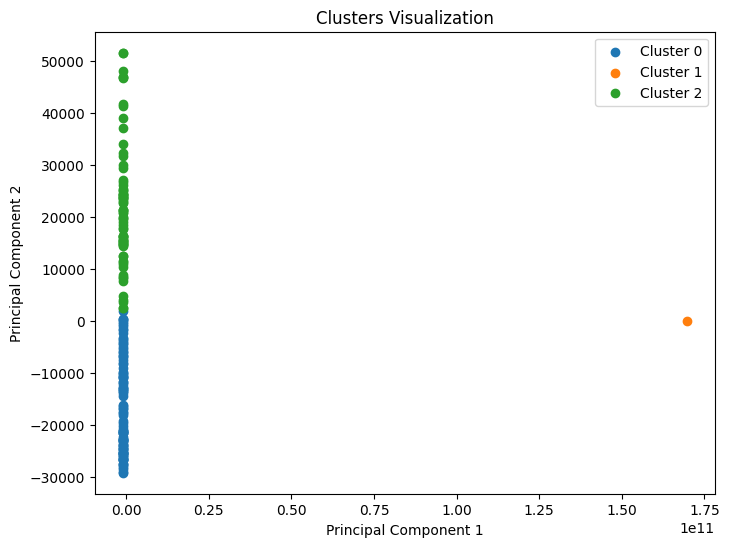

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
if __name__ == "__main__":
    all_features, all_cluster_labels, desired_number_of_clusters = main()

    # Reduce feature vectors to 2 dimensions using PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(all_features)

    # Plot clusters
    plt.figure(figsize=(8, 6))
    for cluster_label in range(desired_number_of_clusters):
        plt.scatter(features_2d[all_cluster_labels == cluster_label, 0], 
                    features_2d[all_cluster_labels == cluster_label, 1], 
                    label=f'Cluster {cluster_label}')
    plt.title('Clusters Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

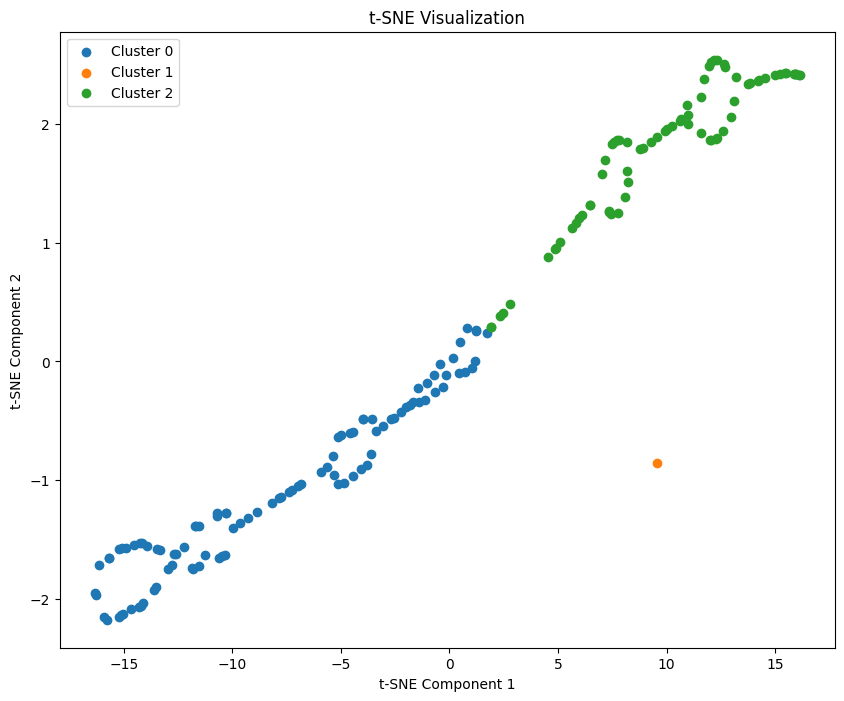

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

def load_features_from_csv(csv_file_path):
    """Load features from a CSV file."""
    data = pd.read_csv(csv_file_path)
    features = data.drop(columns=['File Name', 'Label']).values
    labels = data['Label'].values
    file_names = data['File Name'].values
    return features, labels, file_names

def plot_tsne(features, labels, file_names):
    """Perform t-SNE visualization and plot the results."""
    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=9)
    features_pca = pca.fit_transform(features)
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    features_tsne = tsne.fit_transform(features_pca)
    
    # Plot t-SNE results
    plt.figure(figsize=(10, 8))
    for label in np.unique(labels):
        plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=f'Cluster {label}')
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    
#     # Annotate points with file names
#     for i, file_name in enumerate(file_names):
#         plt.annotate(file_name, (features_tsne[i, 0], features_tsne[i, 1]))
    
    plt.show()

def main():
    # CSV file path containing features
    csv_file_path = "image_features_with_labels_KMeans.csv"  # Change this to your CSV file path
    
    # Load features from CSV file
    features, labels, file_names = load_features_from_csv(csv_file_path)
    
    # Plot t-SNE visualization
    plot_tsne(features, labels, file_names)
    
    return features, labels, file_names

if __name__ == "__main__":
    main()


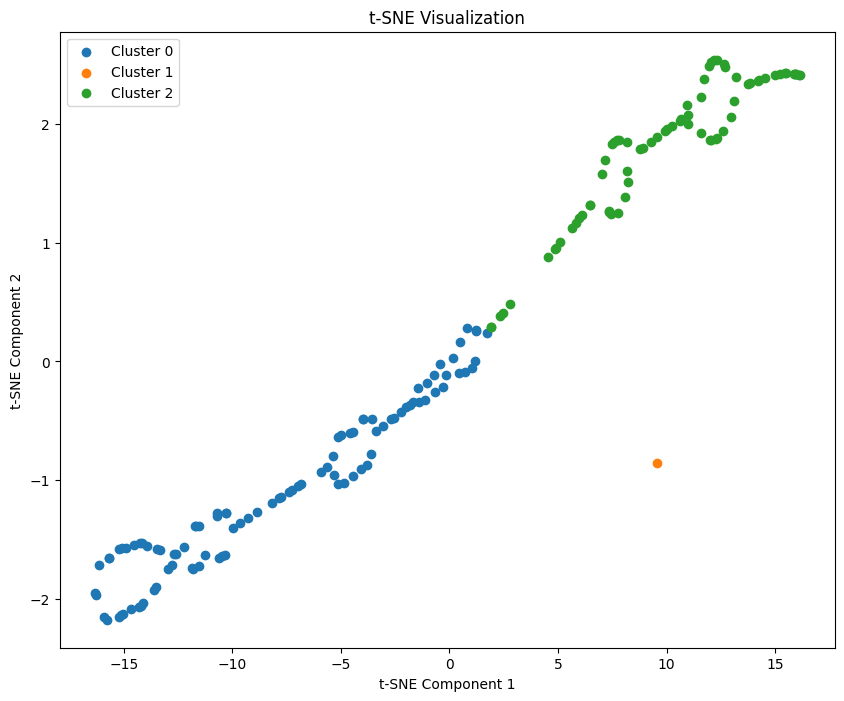

Silhouette Score: 0.666439320066688
Davies-Bouldin Score: 0.2958023043474432


In [10]:
# Perform K-Means clustering and calculate scores

# Call main() to perform clustering and retrieve features, cluster labels, and desired number of clusters
all_features, cluster_labels, desired_number_of_clusters = main()

# Calculate silhouette score
silhouette_avg = silhouette_score(all_features, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Davies-Bouldin score
db_score = davies_bouldin_score(all_features, cluster_labels)
print(f"Davies-Bouldin Score: {db_score}")


Silhouette Score: The silhouette score ranges from -1 to 1. A score closer to 1 indicates that the samples are far away from neighboring clusters, while a score closer to -1 indicates that the samples are close to the neighboring clusters. A score around 0 indicates overlapping clusters.

Davies-Bouldin Score: The Davies-Bouldin score is used to evaluate the average similarity between clusters. It is defined as the average similarity measure of each cluster with its most similar cluster. The score ranges from 0 to positive infinity. The lower the Davies-Bouldin score, the better the clustering. 0 indicates the best possible score.

In [11]:
# Count the occurrences of each cluster label while no CNN is used
cluster_counts = np.bincount(cluster_labels)

# Print the count of points in each cluster
for cluster, count in enumerate(cluster_counts):
    print(f"Cluster {cluster}: {count} points")


Cluster 0: 99 points
Cluster 1: 1 points
Cluster 2: 73 points


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.cluster import KMeans
import csv
import plotly.graph_objects as go

# Load pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to extract features from images using the VGG16 model
def extract_features(image_folder_path):
    features = []
    image_names = []
    for filename in os.listdir(image_folder_path):
        image_path = os.path.join(image_folder_path, filename)
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        features.append(base_model.predict(img_array).flatten())
        image_names.append(filename)  # Store image names
    return np.array(features), image_names

# Example usage
image_folder_path = "E7-images_Unique"
features, image_names = extract_features(image_folder_path)

# Apply K-Means clustering
num_clusters = 3  # You can experiment with different numbers of clusters
kmeans = KMeans(n_clusters=num_clusters,n_init="auto")
kmeans.fit(features)

# Get cluster labels
cluster_labels = kmeans.labels_

# Save image names and corresponding cluster labels to CSV file
output_csv_file = "image_cluster_labels.csv"
with open(output_csv_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image Name', 'Cluster Label'])
    for image_name, label in zip(image_names, cluster_labels):
        writer.writerow([image_name, label])

print(f"Image names and corresponding cluster labels saved to {output_csv_file}.")

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features)

# Create a scatter plot
scatter = go.Scatter3d(
    x=features_tsne[:, 0],
    y=features_tsne[:, 1],
    z=features_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=cluster_labels,  # Color points by cluster label
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    ),
    text=image_names,  # Display image names on hover
    hoverinfo='text'
)

# Create a layout
layout = go.Layout(
    title='Interactive 3D t-SNE Visualization with K-Means Clustering',
    scene=dict(
        xaxis=dict(title='t-SNE Component 1'),
        yaxis=dict(title='t-SNE Component 2'),
        zaxis=dict(title='t-SNE Component 3')
    )
)

# Create a figure
fig = go.Figure(data=[scatter], layout=layout)

# Show the interactive plot
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

In [15]:
# Count the occurrences of each cluster label with CNN features directly used
cluster_counts = np.bincount(cluster_labels)

# Print the count of points in each cluster
for cluster, count in enumerate(cluster_counts):
    print(f"Cluster {cluster}: {count} points")

Cluster 0: 99 points
Cluster 1: 1 points
Cluster 2: 73 points


In [16]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate silhouette score
silhouette_avg = silhouette_score(features, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Davies-Bouldin score
db_score = davies_bouldin_score(features, cluster_labels)
print(f"Davies-Bouldin Score: {db_score}")


NameError: name 'features' is not defined

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate silhouette score
silhouette_avg = silhouette_score(features, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Davies-Bouldin score
db_score = davies_bouldin_score(features, cluster_labels)
print(f"Davies-Bouldin Score: {db_score}")


Silhouette Score: -0.00480949692428112
Davies-Bouldin Score: 6.053514002813991
